## Importing data and EDA

In [ ]:
import pandas as pd
import seaborn as sns

sns.set_theme(style="dark")
sns.set_palette("pastel")

In [4]:
df = pd.read_csv("./data/text.csv")
df.drop("Unnamed: 0", axis=1, inplace=True)
df.head()

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


In [8]:
label_to_id = {
    "sadness":0,
    "joy": 1,
    "love": 2,
    "anger": 3,
    "fear": 4,
    "surprise": 5
}
id_to_label = {v:k for k,v in label_to_id.items()}
df["emotion"] = df["label"].map(id_to_label)

<Axes: xlabel='emotion', ylabel='count'>

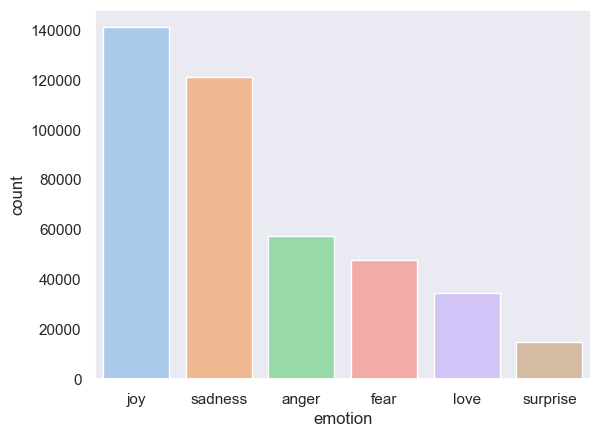

In [18]:
emotion_dist = df.emotion.value_counts().reset_index()
emotion_dist.columns = ["emotion", "count"]
sns.barplot(x="emotion", y="count", data=emotion_dist)

<Axes: xlabel='n_words', ylabel='Count'>

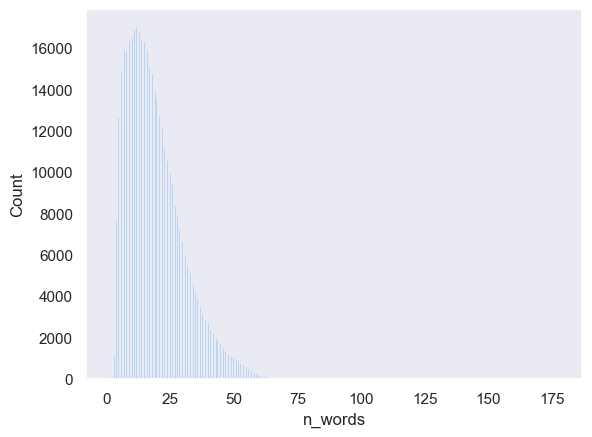

In [ ]:
df["n_words"] = df["text"].str.split().str.len()
sns.histplot(df, x="n_words")

<Axes: xlabel='emotion', ylabel='cnt'>

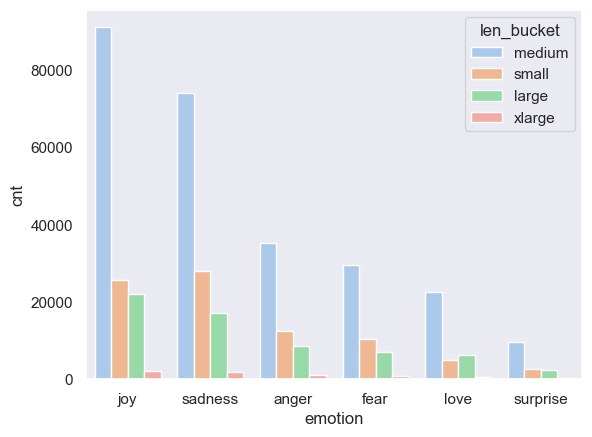

In [27]:
def len_buckets(x):
    if x < 10:
        return "small"
    elif x < 30:
        return "medium"
    elif x < 50:
        return "large"
    else:
        return "xlarge"

df["len_bucket"] = df.n_words.map(len_buckets)
x = df[["emotion", "len_bucket"]].value_counts().reset_index()
x.columns = ["emotion", "len_bucket", "cnt"]
sns.barplot(x, x="emotion", y="cnt", hue="len_bucket")

## Training a Bert based classifier

In [101]:
import torch 
from torch import nn
from torch.nn import functional as F
from transformers import AutoModel, AutoTokenizer
device = "mps"

checkpoint = "prajjwal1/bert-tiny"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
bert_model = AutoModel.from_pretrained(checkpoint).to(device)

In [37]:
model.device

device(type='mps', index=0)

In [41]:
inputs = tokenizer(df.text[0:10].tolist(), return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
model(**inputs)

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-1.4217, -0.1974, -3.4200,  ...,  0.5960,  0.0088,  1.3774],
         [-1.6735,  0.1411, -0.4430,  ..., -1.3566,  0.1415,  1.0689],
         [-1.3555, -0.4540, -0.9067,  ..., -1.2008, -0.5649,  2.0236],
         ...,
         [-1.3208, -0.1553, -0.6254,  ...,  0.7651, -1.1930,  1.7198],
         [-1.2291, -0.0975, -0.5818,  ...,  0.6200, -0.5607,  2.7154],
         [-0.6381, -0.8642, -0.4012,  ...,  0.8525, -0.6343,  2.4986]],

        [[-1.5776, -0.3786, -4.5858,  ...,  0.1621, -0.2806,  1.1588],
         [-1.2961,  0.3928, -0.3564,  ..., -1.0980, -0.7440,  0.6168],
         [-1.0788, -0.5728,  0.6087,  ..., -2.9751, -0.8776,  0.6535],
         ...,
         [-0.9678,  0.5244, -0.3406,  ...,  0.6109, -1.3456,  1.0132],
         [-1.3892,  0.4409, -0.3329,  ..., -0.2299, -0.6662, -0.2661],
         [-1.7254, -0.2014,  0.3691,  ...,  0.3882, -1.3976,  0.8405]],

        [[-1.6570, -0.4850, -4.0459,  ..., -0.2572,  

### Creating Dataset and DataLoader

In [ ]:
from torch.utils.data import Dataset, DataLoader

class EmotionDataset(Dataset):

    def __init__(self, df, tokenizer, max_len=512):
        self.text = df.text.tolist()
        self.labels = df.label.tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = self.text[index]
        return {
            "text": text,
            "labels": self.labels[index]
        }


class EmotionCollator:
    def __init__(self, tokenizer, max_len=512, device="mps"):
        self.tokenizer = tokenizer
        self.max_len = max_len

    def collate_fn(self, batch):
        sentence_batch = [example["text"] for example in batch]
        labels_batch = [example["labels"] for example in batch]

        inputs = self.tokenizer(
            sentence_batch,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=self.max_len
        )

        labels = torch.tensor(labels_batch, dtype=torch.long)

        return {
            'input_ids': inputs['input_ids'].to(device),
            'attention_mask': inputs['attention_mask'].to(device),
            'labels': labels
        }

In [97]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=43,
    stratify=df.emotion,
    shuffle=True
)

In [123]:
train_ds = EmotionDataset(train_df, tokenizer)
test_ds = EmotionDataset(test_df, tokenizer)
emotion_collator = EmotionCollator(tokenizer)

train_dataloader = DataLoader(
    train_ds,
    batch_size=32,
    shuffle=True,
    collate_fn=emotion_collator.collate_fn
)
test_dataloader = DataLoader(
    test_ds,
    batch_size=32,
    shuffle=True,
    collate_fn=emotion_collator.collate_fn
)

## Create classification model

In [119]:
class EmotionClassifier(nn.Module):
    def __init__(self, bert_model, num_labels, expansion_factor=2):
        super(EmotionClassifier, self).__init__()
        self.bert_model = bert_model
        H = bert_model.config.hidden_size
        self.linear1 = nn.Linear(H, H * expansion_factor)
        self.linear2 = nn.Linear(H * expansion_factor, num_labels)

    def forward(self, inputs):
        x = self.bert_model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"]).pooler_output
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x

## Training loop

In [ ]:
classifier_model = EmotionClassifier(bert_model, num_labels=5).to(device)
optimizer = torch.optim.Adam(classifier_model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()
epochs = 5


In [ ]:
def train_model(model, optimizer, criterion, batch):
    optimizer.zero_grad()
    outputs = model(batch)
    loss = criterion(outputs, batch["labels"])
    loss.backward()
    optimizer.step()
    return loss

def evaluate_model(model, criterion, batch):
    with torch.no_grad():
        outputs = model(batch)
        loss = criterion(outputs, batch["labels"])

    return loss

In [125]:
len(train_dataloader), len(test_dataloader)

(10421, 2606)

In [ ]:
for epoch in range(epochs):
    
    train_loss = 0
    for batch_idx, batch in enumerate(train_dataloader):
        classifier_model.train()
        loss = train_model(classifier_model, optimizer, criterion, batch)
        train_loss += loss.item()

        if batch_idx % 100 == 0:
            classifier_model.eval()
            total_loss = 0
            for batch in test_dataloader:
                loss = evaluate_model(classifier_model, criterion, batch)
                total_loss += loss.item()

            print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(test_dataloader)}")

10421